### 필요한 라이브러리 Import

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

import time
import re
import os
import io
import tarfile
from konlpy.tag import Mecab

import matplotlib as mpl
 
from tqdm import tqdm    # tqdm
import random

%config InlineBackend.figure_format = 'retina'
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

'/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

### 데이터 다운로드 및 확인

In [2]:
file_zip = tarfile.open(os.getenv('HOME')+"/aiffel/s2s_translation/korean-english-park.train.tar.gz")
file_zip.extractall(os.getenv('HOME')+"/aiffel/s2s_translation/")
file_zip.close()

In [3]:
path_ko = os.getenv('HOME')+"/aiffel/s2s_translation/korean-english-park.train.ko"
path_en = os.getenv('HOME')+"/aiffel/s2s_translation/korean-english-park.train.en"

In [4]:
with open(path_ko, "r") as f:
    ko_raw = f.read().splitlines()

print("Data Size:", len(ko_raw))
print("Example:")

for sen in ko_raw[0:100][::20]: print(">>", sen)

Data Size: 94123
Example:
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
>> "경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다."
>> 수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다.
>> 또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 것과 같은 유산소 활동에서 얻는 운동 효과를 심장과 폐에 주지 않기 때문에, 연구학자들은 근력 운동이 심장에 큰 영향을 미치는지 여부에 대해 논쟁을 해왔다.


In [5]:
with open(path_en, "r") as f:
    en_raw = f.read().splitlines()

print("Data Size:", len(en_raw))
print("Example:")

for sen in en_raw[0:100][::20]: print(">>", sen)

Data Size: 94123
Example:
>> Much of personal computing is about "can you top this?"
>> Amid mounting pressure on North Korea to abandon its nuclear weapons program Japanese and North Korean diplomats have resumed talks on normalizing diplomatic relations.
>> “Guard robots are used privately and professionally to detect intruders or fire,” Karlsson said.
>> Authorities from the Water Resources Ministry plan to begin construction next year on the controversial and hugely expensive project.
>> Researchers also have debated whether weight-training has a big impact on the heart, since it does not give the heart and lungs the kind of workout they get from aerobic activities such as brisk walking or running for at least 20 minutes.


In [6]:
data =  pd.DataFrame(zip(ko_raw, en_raw), columns=["ko", "en"])
data.head()

,ko,en
0,"개인용 컴퓨터 사용의 상당 부분은 ""이것보다 뛰어날 수 있느냐?""","Much of personal computing is about ""can you t..."
1,모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하...,so a mention a few weeks ago about a rechargea...
2,그러나 이것은 또한 책상도 필요로 하지 않는다.,"Like all optical mice, But it also doesn't nee..."
3,"79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분...",uses gyroscopic sensors to control the cursor ...
4,정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이 실패로 돌아갔...,Intelligence officials have revealed a spate o...


* 중복값 확인

In [7]:
data.duplicated().value_counts()

False    78968
True     15155
dtype: int64

* 중복값 제거

In [8]:
data.drop_duplicates(inplace=True)
len(data)

78968

* 문장길이 확인

In [9]:
def show_data(num_tokens):
    num_tokens = np.array(num_tokens)
    
    print('문장길이 평균 : ', np.mean(num_tokens))
    print('문장길이 최대 : ', np.max(num_tokens))
    print('문장길이 최소 : ', np.min(num_tokens))
    print('문장길이 표준편차 : ', np.std(num_tokens))
    
    max_len = np.max(num_tokens)
    
    plt.hist(num_tokens, bins = max_len, range=[0, max_len], facecolor='b')
    plt.show()

In [10]:
ko_text = [len(token.split()) for token in data["ko"]]
en_text = [len(token.split()) for token in data["en"]]

문장길이 평균 :  14.719240705095736
문장길이 최대 :  82
문장길이 최소 :  1
문장길이 표준편차 :  6.371726958851952


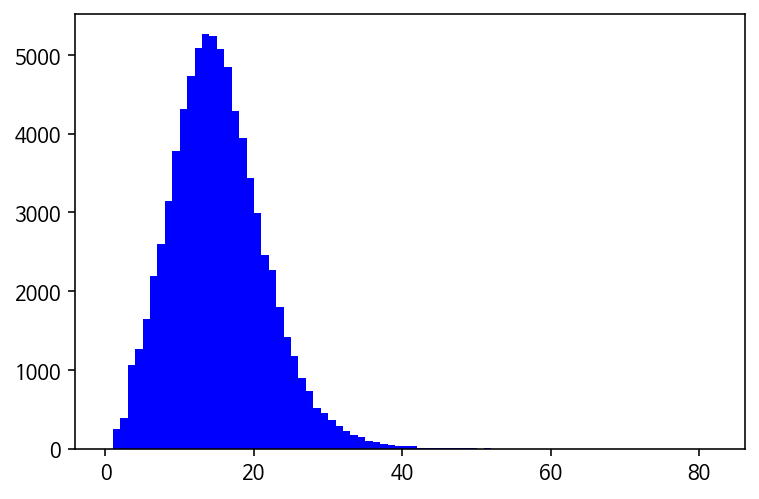

In [11]:
show_data(ko_text)

문장길이 평균 :  22.152340188430756
문장길이 최대 :  90
문장길이 최소 :  1
문장길이 표준편차 :  9.891886797733385


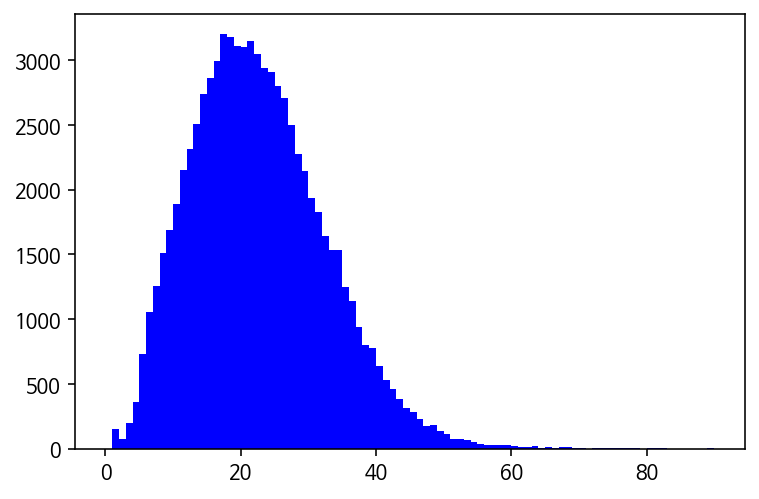

In [12]:
show_data(en_text)

* 문장길이 40이하만 사용하기 위해 시각화를 해보았는데, 영어 문장을 40이하로 자르면 좋을것 같습니다.

In [13]:
df = data.copy()
df["len"] = df["en"].apply(lambda x: len(x.split()))
df = df.loc[df["len"] < 41]
df.drop(["len"], axis="columns", inplace=True)

In [14]:
df

,ko,en
0,"개인용 컴퓨터 사용의 상당 부분은 ""이것보다 뛰어날 수 있느냐?""","Much of personal computing is about ""can you t..."
1,모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하...,so a mention a few weeks ago about a rechargea...
2,그러나 이것은 또한 책상도 필요로 하지 않는다.,"Like all optical mice, But it also doesn't nee..."
3,"79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분...",uses gyroscopic sensors to control the cursor ...
4,정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이 실패로 돌아갔...,Intelligence officials have revealed a spate o...
...,...,...
94118,“우리는 3월 8일 김승연 회장과 그의 아들이 보복폭행에 가담한 혐의를 찾기 위해 ...,””We are hoping to seize material evidence to ...
94119,월요일 술집 종업원 6명은 김회장과 아들에게 폭행을 당했음을 진술했다고 경찰은 말했다.,"” On Monday, police secured statements from si..."
94120,그러나 불충분한 증거 확보로 수사에 어려움이 있다.,But the lack of material evidence is making it...
94121,김회장과 그의 아들은 보복폭행 혐의를 강력히 부인하고 있다.,Kim and his son both deny the allegations.


### 데이터 전처리
> 디코더에 적용시키기 떄문에 &#60;sos&#62;, &#60;eos&#62; 로 바꾸겠습니다.

In [15]:
def preprocess_sentence(sentence, s_token=False, e_token=False):
    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Zㄱ-ㅎ가-힣0-9?.!,]+", " ", sentence)

    sentence = sentence.strip()
    
    if s_token:
        sentence = '<sos> ' + sentence

    if e_token:
        sentence += ' <eos>'
        
    return sentence

In [16]:
df["ko"] = df["ko"].apply(preprocess_sentence)
df["en"] = df["en"].apply(lambda x: preprocess_sentence(x, True, True))
df.head()

,ko,en
0,개인용 컴퓨터 사용의 상당 부분은 이것보다 뛰어날 수 있느냐 ?,<sos> much of personal computing is about can ...
1,모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하...,<sos> so a mention a few weeks ago about a rec...
2,그러나 이것은 또한 책상도 필요로 하지 않는다 .,"<sos> like all optical mice , but it also does..."
3,"79 . 95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목 , 팔 , 그외에 어...",<sos> uses gyroscopic sensors to control the c...
4,정보 관리들은 동남 아시아에서의 선박들에 대한 많은 테러 계획들이 실패로 돌아갔음을...,<sos> intelligence officials have revealed a s...


### 토큰화

In [17]:
def tokenize(corpus, kor=False):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    
    cleaned_corpus = corpus
    if kor:
        m = Mecab()
        
        cleaned_corpus = []
        for sen in corpus:
            cleaned_corpus.append(m.morphs(sen))
        
    tokenizer.fit_on_texts(cleaned_corpus)
    
    tensor = tokenizer.texts_to_sequences(cleaned_corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

* 한국어는 Mecab을 사용하기 때문에 예제함수를 조금 변형했습니다.

In [18]:
enc_tensor, enc_tokenizer = tokenize(df["ko"], True)
dec_tensor, dec_tokenizer = tokenize(df["en"])

### 어텐션
> 드롭아웃을 0.5 추가해 보겠습니다.

In [19]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]

        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)

        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        
        attn = tf.nn.softmax(score, axis=1)

        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn
    
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units,
                                       dropout=0.5,
                                       return_sequences=True)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.gru(out)
        
        return out
    
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units,
                                       dropout=0.5,
                                       return_sequences=True,
                                       return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)

        out = self.embedding(x)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)
        
        out, h_dec = self.gru(out)
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)

        return out, h_dec, attn

* 유닛과 임베딩차원을 예제와 똑같이 했더니 용량을 감당하지 못하고 터졌습니다. 그래서 조금 낮춰서 진행했습니다.

In [20]:
BATCH_SIZE     = 128
SRC_VOCAB_SIZE = len(enc_tokenizer.index_word) + 1
TGT_VOCAB_SIZE = len(dec_tokenizer.index_word) + 1

units         = 256
embedding_dim = 256

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

# sample input
sequence_len = 30

sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))
sample_output = encoder(sample_enc)

print ('Encoder Output:', sample_output.shape)

sample_state = tf.random.uniform((BATCH_SIZE, units))

sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                     sample_state, sample_output)

print ('Decoder Output:', sample_logits.shape)
print ('Decoder Hidden State:', h_dec.shape)
print ('Attention:', attn.shape)

Encoder Output: (128, 30, 256)
Decoder Output: (128, 44864)
Decoder Hidden State: (128, 256)
Attention: (128, 30, 1)


* 옵티마이저 정의

In [21]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

* 로스함수 정의

In [22]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)

* 트레인스텝 정의
> 데이터가 적어 트레인만 진행했습니다.

In [23]:
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]
        
        dec_src = tf.expand_dims([dec_tok.word_index['<sos>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

* 트레인만 진행하기 때문에 20번 학습하겠습니다.

In [24]:
EPOCHS = 20

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_tensor.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)    # tqdm

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_tensor[idx:idx+BATCH_SIZE],
                                dec_tensor[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))    # tqdm
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))    # tqdm

Epoch 20: 100%|██████████| 591/591 [12:28<00:00,  1.27s/it, Loss 2.5032]


* 로스값이 떨어지는걸 보니 조금만 더 학습했으면 좋지 않았을까 아쉽습니다. 시간이 없어 그대로 진행하겠습니다.

### 모델 테스트

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator


Input: 오바마는 대통령이다 .
Predicted translation: the world s . <eos> 


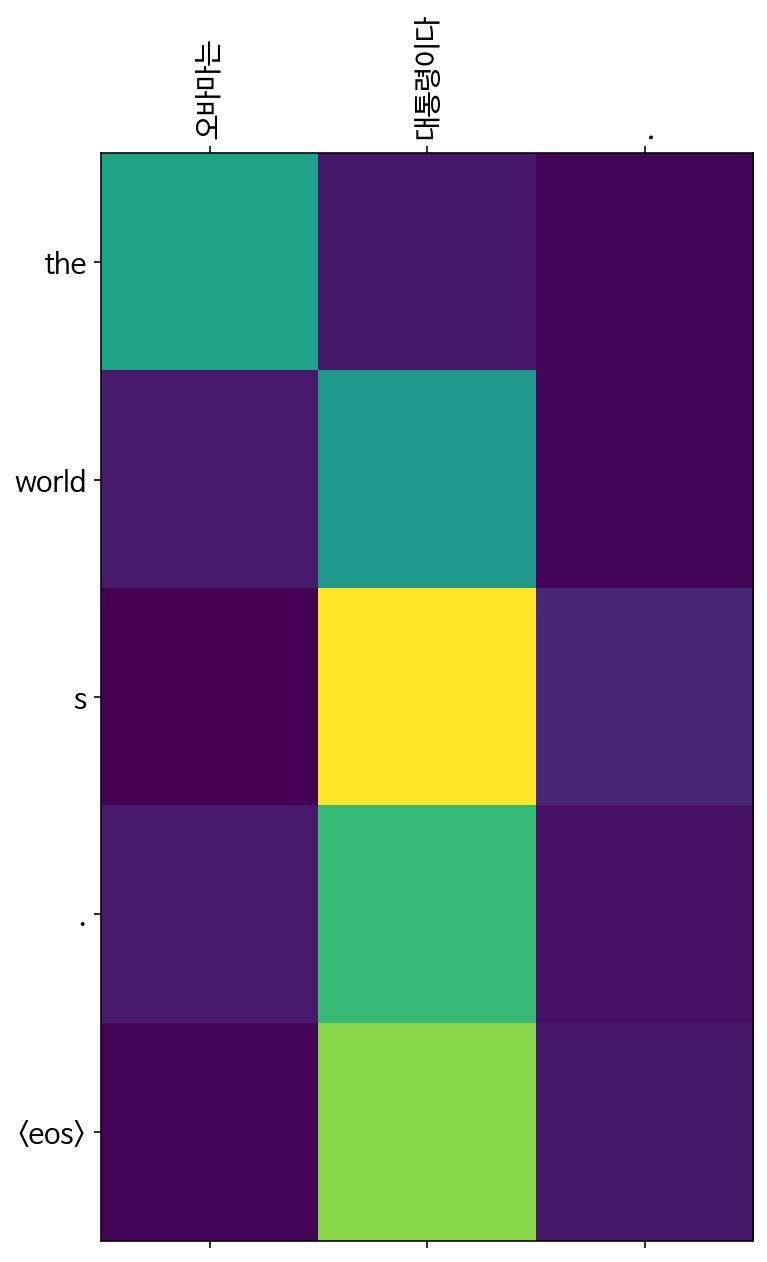

In [25]:
def evaluate(sentence, encoder, decoder):
    attention = np.zeros((dec_tensor.shape[-1], enc_tensor.shape[-1]))
    
    sentence = preprocess_sentence(sentence)
    inputs = enc_tokenizer.texts_to_sequences([sentence.split()])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           maxlen=enc_tensor.shape[-1],
                                                           padding='post')

    result = ''

    enc_out = encoder(inputs)

    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([dec_tokenizer.word_index['<sos>']], 0)

    for t in range(dec_tensor.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

        result += dec_tokenizer.index_word[predicted_id] + ' '

        if dec_tokenizer.index_word[predicted_id] == '<eos>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention


def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    attention = attention[:len(result.split()), :len(sentence.split())]
    plot_attention(attention, sentence.split(), result.split(' '))


translate("오바마는 대통령이다.", encoder, decoder)

Input: 시민들은 도시 속에 산다 .
Predicted translation: the world s . <eos> 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator


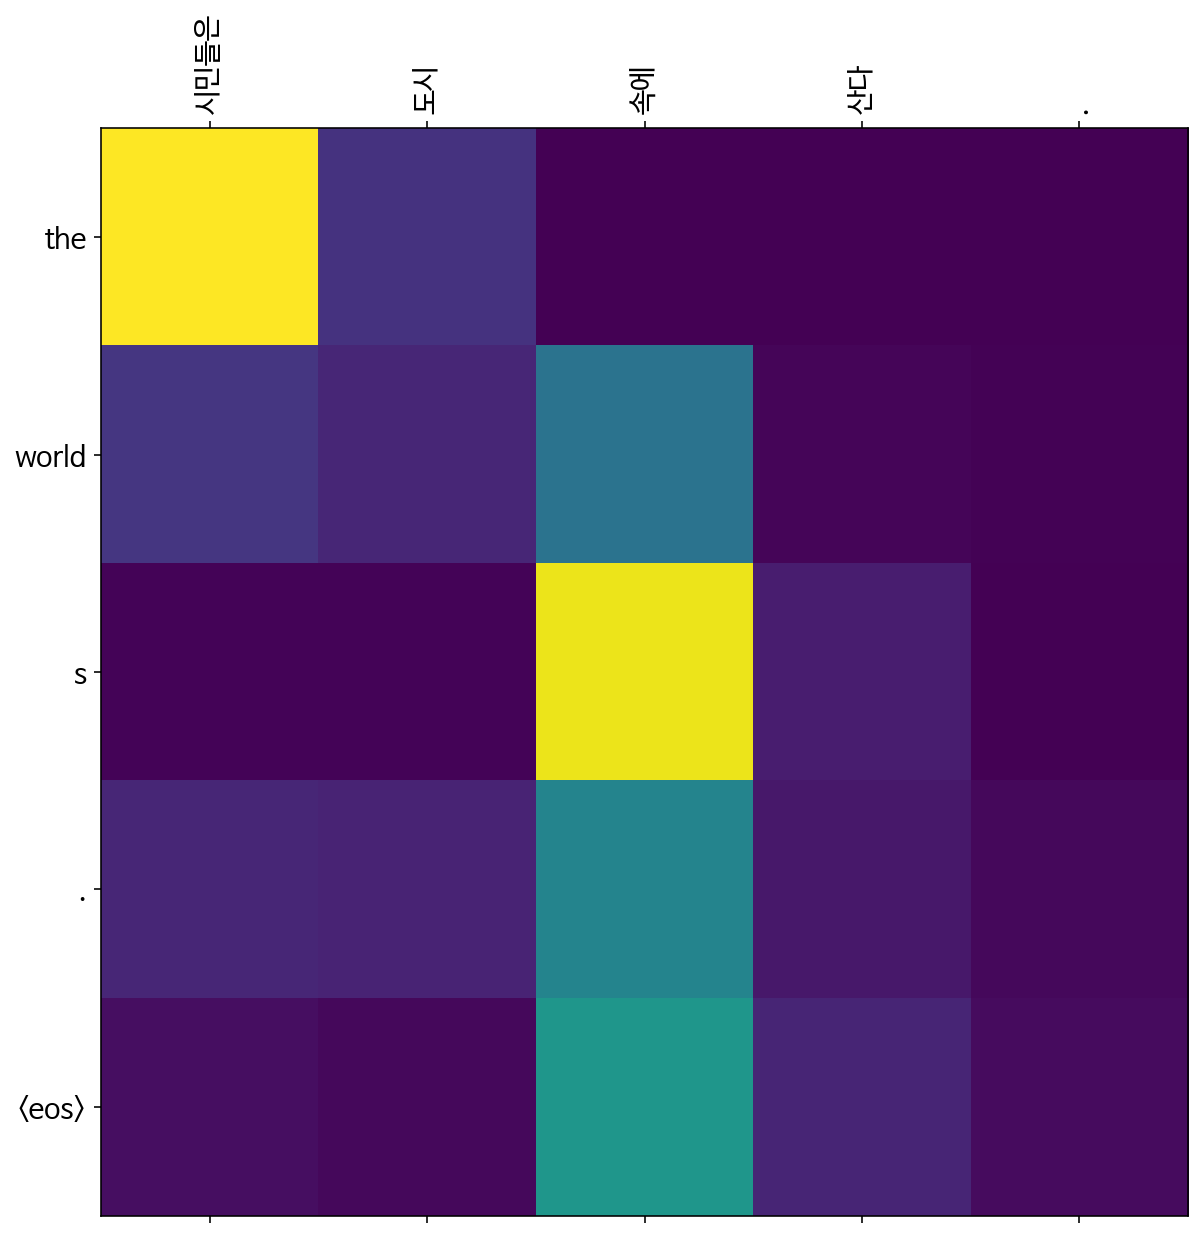

In [28]:
translate("시민들은 도시 속에 산다.", encoder, decoder)

Input: 커피는 필요 없다 .
Predicted translation: the new york s not not to the world s . <eos> 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator


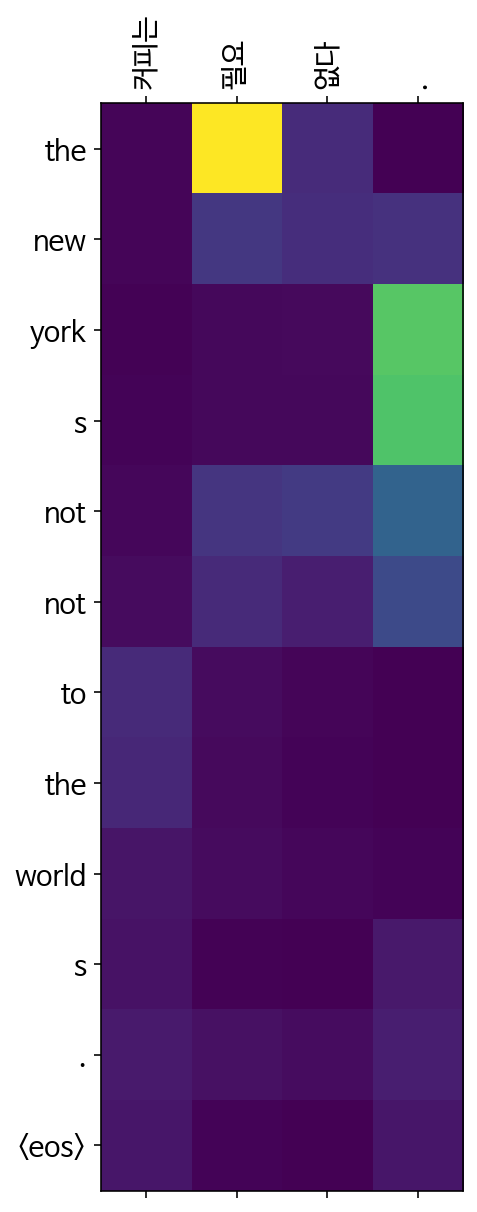

In [29]:
translate("커피는 필요 없다.", encoder, decoder)

Input: 일곱 명의 사망자가 발생했다 .
Predicted translation: the government was a new york . <eos> 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator


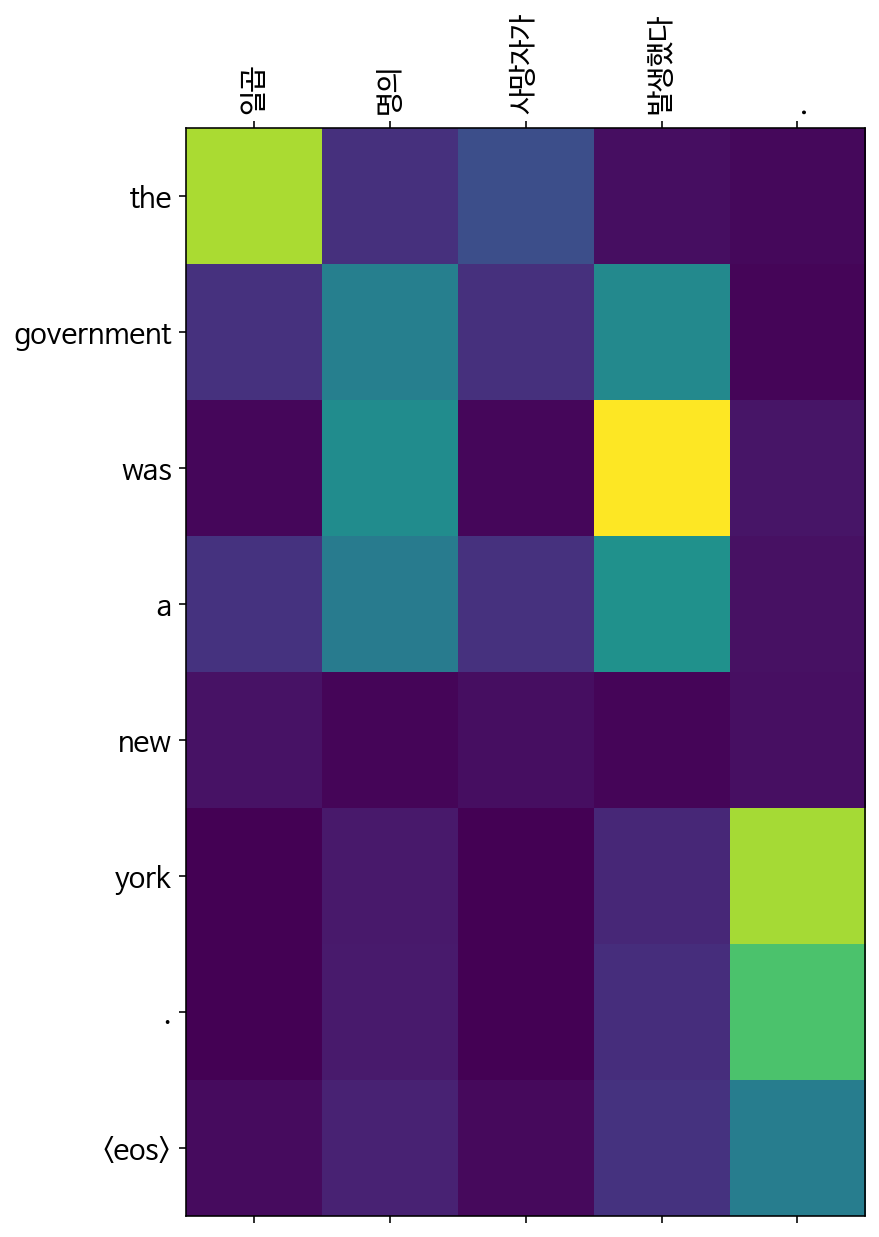

In [30]:
translate("일곱 명의 사망자가 발생했다.", encoder, decoder)

### 회고
* 학습이 덜 끝난것 같습니다. 커피를 뉴욕이라 번역한것을 보니 뉴욕이란 문장에 커피란 단어가 꽤 연관성이 있었나 생각이 듭니다.
* 모델 학습시 패딩을 pre로 해봤는데 아무래도 번역을 하는것이다 보니 앞부분이 패딩값이 들어오면 모델의 성능이 많이 떨어지는것을 확인했습니다.
* 하이퍼 파라미터값을 높여 학습을 시켜보았더니 메모리를 감당하지 못하고 학습이 진행되지 않았습니다.